In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


| Parameter    | Units                 | Physical Role                                        |
|--------------|-----------------------|------------------------------------------------------|
| $$ \mu $$    | Pa·s                  | Dynamic viscosity of blood                           |
| $$ k_t $$    | $$ \text{m}^2 $$      | 3D tissue permeability                               |
| $$ k_v $$    | $$ \text{m}^2 $$      | Axial permeability along the vessel                  |
| $$ \gamma $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Vessel wall permeability coefficient (coupling tissue & vessel) |
| $$ \gamma_R $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Boundary outflow (Robin) permeability                 |
| $$ \gamma_a $$ | m                    | Terminal vessel coupling length scale (hydraulic conductance at end) |

In [2]:
# @title Install nonstandard libraries
%%capture
!pip install ipywidgets
!pip install vtk
!pip install meshio
!pip install pyvista
!pip install Rtree

import os, re

def replace_in_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Replace 'ufl' with 'ufl_legacy'
    content = re.sub(r'\bufl\b', 'ufl_legacy', content)

    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(content)

def process_directory(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.py'):
                file_path = os.path.join(root, file)
                replace_in_file(file_path)

# dolfin
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"

# block
try:
    import block
except ImportError:
    !git clone "https://bitbucket.org/fenics-apps/cbc.block/src/master/"
    !pip install master/

# fenics_ii
try:
    import xii
except ImportError:
    !git clone "https://github.com/MiroK/fenics_ii"
    process_directory("fenics_ii/")
    !pip install fenics_ii/

# graphnics
try:
    import graphnics
except ImportError:
    !git clone "https://github.com/IngeborgGjerde/graphnics"
    !pip install graphnics/

In [ ]:
WD_PATH = "/content/drive/MyDrive/Research/3d-1d"

import sys, os
sys.path.append(os.path.join(WD_PATH, 'modules'))

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import importlib
from graphnics import *

In [ ]:
# @title Define G = .vtk domain read
import vtk

def read_vtk(file_path):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(file_path)
    reader.Update()
    output = reader.GetOutput()

    G = FenicsGraph()

    damage_array = output.GetPointData().GetArray("Damage")
    for i in range(output.GetNumberOfPoints()):
        point = output.GetPoint(i)
        damage_value = damage_array.GetValue(i)
        G.add_node(i, pos=np.array(tuple(point)), damage=damage_value)

    radius_array = output.GetCellData().GetArray("Radius")
    for i in range(output.GetNumberOfCells()):
        cell = output.GetCell(i)
        point_ids = [cell.GetPointId(j) for j in range(cell.GetNumberOfPoints())]
        for j in range(len(point_ids) - 1):
            u = point_ids[j]
            v = point_ids[j + 1]
            radius_value = radius_array.GetValue(i) if radius_array else None
            G.add_edge(u, v, radius=radius_value)

    return G

file_path = "/content/drive/MyDrive/Research/3D-1D/oncopigData/ZPAF23S021/20230503/sortedDomain.vtk"
# file_path = WD_PATH + '/oncopigReferenceData/ZPAF23S018/20230531/vesselNetwork_upDated.vtk'
G = read_vtk(file_path)

In [ ]:
#@title Define G = test graph
# Import the necessary library
G = FenicsGraph()

# Define the node labels and their corresponding integer IDs
node_mapping = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H'
}

# Define the coordinates for each node (x, y, z)
node_coords = {
    0: [0.000, 0.020, 0.015],    # A
    1: [0.010, 0.020, 0.015],   # B
    2: [0.022, 0.013, 0.015],   # C
    3: [0.022, 0.028, 0.015],   # D
    4: [0.015, 0.005, 0.015],    # E
    5: [0.015, 0.035, 0.015],   # F
    6: [0.038, 0.005, 0.015],    # G
    7: [0.038, 0.035, 0.015]    # H
}

# Define the edges along with their radii
edges_with_radii = [
    (0, 1, 0.004),  # AB
    (1, 2, 0.003),  # BC
    (1, 3, 0.003),  # BD
    (2, 4, 0.002),  # CE
    (2, 6, 0.003),  # CG
    (3, 5, 0.002),  # DF
    (3, 7, 0.003)   # DH
]

# Create the FenicsGraph object
G = FenicsGraph()

# Add nodes to the graph with their positions
for node_id, coord in node_coords.items():
    G.add_node(node_id, pos=coord)

# Add edges to the graph with their radii
for u, v, radius in edges_with_radii:
    G.add_edge(u, v, radius=radius)

for edge_id, (u, v, data) in enumerate(G.edges(data=True)):
    print(f"Edge {edge_id}: ({u}, {v}) - Radius: {data['radius']}")

In [ ]:
import FEMSinkVelo

In [ ]:
importlib.reload(FEMSinkVelo)

<module 'FEMSinkVelo' from '/content/drive/MyDrive/Research/3d-1d/modules/FEMSinkVelo.py'>

In [ ]:
fem_test = FEMSinkVelo.FEMSinkVelo(
    G=G,
    gamma = 1.0,
    gamma_R = 1.0e2,
    gamma_v = 1.0e2,
    gamma_a = 0,
    mu = 1.0e-3, # Viscosity
    k_t = 1.0e-10, # Tissue permeability in 3D
    k_v = 3.33e-11, # Vessel permeability in 1D
    P_in = 100.0 * 133.322, # 100 mmHg
    p_cvp = 1.0 * 133.322, # 1 mmHg
    Lambda_inlet = [0],
    Lambda_padding_min = 0.008
)

Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 500.30it/s]


Found different Arguments with same number and part.
Did you combine test or trial functions from different spaces?
The Arguments found are:
  v_0
  v_1
  v_0
  v_1


ERROR:UFL_LEGACY:Found different Arguments with same number and part.
Did you combine test or trial functions from different spaces?
The Arguments found are:
  v_0
  v_1
  v_0
  v_1


UFLException: Found different Arguments with same number and part.
Did you combine test or trial functions from different spaces?
The Arguments found are:
  v_0
  v_1
  v_0
  v_1

In [ ]:
import Visualizer

In [ ]:
importlib.reload(Visualizer)

<module 'Visualizer' from '/content/drive/MyDrive/Research/3d-1d/modules/Visualizer.py'>

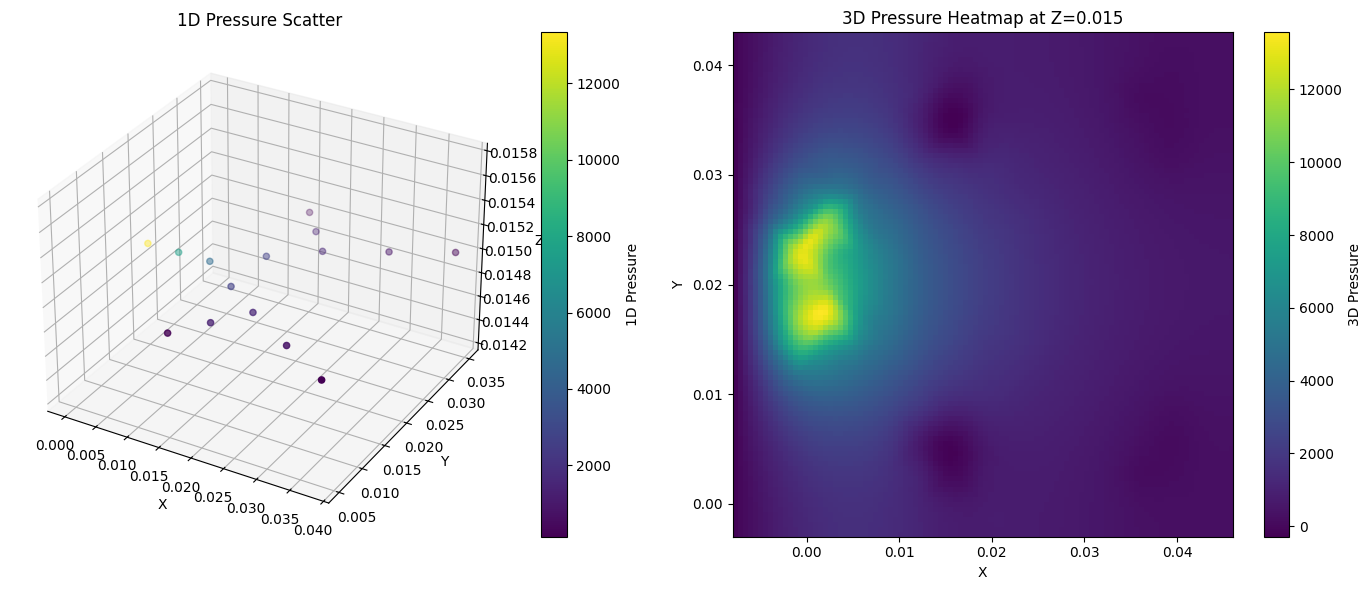

In [ ]:
Visualizer.Visualizer.plot(fem_test.uh1d, fem_test.uh3d, )

In [ ]:
print(fem_test.calculate_total_outflow())
print(fem_test.calculate_1d_inflow())

1.9426703465677597e-06
1.9426703465677597e-06


In [ ]:
import numpy as np
from scipy.optimize import minimize

def black_box_flow(gamma, gamma_R, gamma_a, gamma_v, k_v=3.33e-11):
  fem_test = FEMSinkVelo.FEMSinkVelo(
      G=G,
      gamma=gamma,
      gamma_R=gamma_R,
      gamma_a=gamma_a,
      gamma_v=gamma_v,
      mu=1.0e-3,
      k_t=1.0e-10,
      k_v=k_v,            # locked at 3.33e-11
      P_in=100.0*133.322,
      p_cvp=1.0*133.322,
      Lambda_inlet=[0],
      Lambda_padding_min=0.008
  )
  flow_val = fem_test.calculate_1d_inflow()
  return flow_val

def cost_function_log(params_log, target_flow=500.6, k_v=3.33e-11):
    # Convert from log10-space to linear
    gamma_linear    = 10.0**(params_log[0])
    gamma_R_linear  = 10.0**(params_log[1])
    gamma_a_linear  = 10.0**(params_log[2])
    gamma_v_linear  = 10.0**(params_log[3])

    # Evaluate the flow from the PDE solver
    flow_val = black_box_flow(
        gamma_linear,
        gamma_R_linear,
        gamma_a_linear,
        gamma_v_linear,
        k_v=k_v
    )

    # Least-squares difference from the target flow
    return (flow_val - target_flow)**2

def multi_param_fit(
    target_flow=500.6,
    k_v=3.33e-11,
    initial_guess_log=None,
    max_iter=50
):
    if initial_guess_log is None:
        initial_guess_log = [0.0, 0.0, 0.0, 0.0]

    result = minimize(
        fun=lambda p: cost_function_log(p, target_flow=target_flow, k_v=k_v),
        x0=np.array(initial_guess_log),
        method='Nelder-Mead',
        options={'maxiter': max_iter, 'disp': True}
    )

    best_log = result.x
    gamma_opt   = 10.0**(best_log[0])
    gammaR_opt  = 10.0**(best_log[1])
    gammaA_opt  = 10.0**(best_log[2])
    gammaV_opt  = 10.0**(best_log[3])

    flow_final = black_box_flow(gamma_opt, gammaR_opt, gammaA_opt, gammaV_opt, k_v)

    return {
        'success': result.success,
        'status': result.status,
        'message': result.message,
        'n_iters': result.nit,
        'cost_final': result.fun,
        'gamma':   gamma_opt,
        'gamma_R': gammaR_opt,
        'gamma_a': gammaA_opt,
        'gamma_v': gammaV_opt,
        'flow_final': flow_final
    }

res = multi_param_fit(target_flow=500.6, k_v=3.33e-11, max_iter=30)

print("Optimization successful?", res['success'])
print("Status code:", res['status'])
print("Message:", res['message'])
print("Number of iterations:", res['n_iters'])
print("Final cost:", res['cost_final'])
print(f"gamma    = {res['gamma']:8.4g}")
print(f"gamma_R  = {res['gamma_R']:8.4g}")
print(f"gamma_a  = {res['gamma_a']:8.4g}")
print(f"gamma_v  = {res['gamma_v']:8.4g}")
print(f"flow     = {res['flow_final']:8.4g}")

Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 731.65it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 768.34it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 512.56it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 872.59it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 753.46it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 690.12it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 692.72it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 510.96it/s]


Applied BC! Non-empty list
Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 441.25it/s]


Applied BC! Non-empty list
Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 416.16it/s]


Applied BC! Non-empty list
Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 743.15it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 896.08it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 827.76it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 677.85it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 860.57it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 756.59it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 810.26it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 725.02it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 566.02it/s]


Applied BC! Non-empty list
Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 540.29it/s]


Applied BC! Non-empty list
Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 776.50it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 742.56it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 727.29it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 742.09it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 818.34it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 685.84it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 714.34it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 669.87it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 560.52it/s]


Applied BC! Non-empty list
Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 524.52it/s]


Applied BC! Non-empty list
Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 487.99it/s]


Applied BC! Non-empty list
Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 835.27it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 536.93it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 769.89it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 656.72it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 595.22it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 826.13it/s]


Applied BC! Non-empty list
Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 731.51it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 771.67it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 486.14it/s]


Applied BC! Non-empty list
Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 567.15it/s]


Applied BC! Non-empty list
Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 754.91it/s]


Applied BC! Non-empty list
Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 772.08it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 625.47it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 743.35it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 754.42it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 642.46it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 669.36it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 660.36it/s]

Applied BC! Non-empty list


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 537.52it/s]


Applied BC! Non-empty list
Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 546.17it/s]


Applied BC! Non-empty list
Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 534.76it/s]


Applied BC! Non-empty list
Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 783.47it/s]

Applied BC! Non-empty list



<ipython-input-131-aff70639816a>:50: RuntimeWarning: Maximum number of iterations has been exceeded.
  result = minimize(


Omega bounding coordinates:
Min: [-0.008 -0.003  0.007]
Max: [0.046 0.043 0.023]


Averaging over 14 cells: 100%|██████████| 14/14 [00:00<00:00, 828.24it/s]


Applied BC! Non-empty list
Optimization successful? False
Status code: 2
Message: Maximum number of iterations has been exceeded.
Number of iterations: 30
Final cost: 250600.3580525868
gamma    =   0.1658
gamma_R  =     1.06
gamma_a  =    2.245
gamma_v  =     1.09
flow     = 1.945e-06


In [ ]:
fem_test.save_vtk(os.path.join(WD_PATH, 'perfusion_results', 'abc1'))

In [ ]:
from typing import Union, Sequence
import numpy as np
from dolfin import Function, Point

def probe_pressure_at_point(fem_test: "FEMSink",
                            point: Union[Sequence[float], np.ndarray]) -> float:

    if not isinstance(point, (list, tuple, np.ndarray)):
        raise TypeError("Point must be a list, tuple, or numpy array of three coordinates.")

    if len(point) != 3:
        raise ValueError("Point must have exactly three coordinates (x, y, z).")

    fenics_point = Point(*point)

    mesh = fem_test.Omega
    if not mesh.bounding_box_tree().compute_first_entity_collision(fenics_point) < mesh.num_cells():
        raise ValueError(f"Point {point} is outside the mesh domain.")

    try:
        pressure = fem_test.uh3d(fenics_point)
    except Exception as e:
        raise RuntimeError(f"Failed to evaluate uh3d at point {point}: {e}")

    return pressure

print(probe_pressure_at_point(fem_test, [0.00, 0.02, 0.02]))

10162.869128805627
